In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

### DataSet 1: Stroke Data

In [2]:
data = pd.read_csv("C:\\Users\\vrsru\\Downloads\\healthcare-dataset-stroke-data.csv")

In [3]:
print(data.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
#Handle missing data
num_features = ['bmi', 'avg_glucose_level']
cat_features = ['smoking_status']
num_imputer = SimpleImputer(strategy='mean')
data[num_features] = num_imputer.fit_transform(data[num_features])
cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_features] = cat_imputer.fit_transform(data[cat_features])

In [5]:
#Encode Categorical Value
data['ever_married'] = data['ever_married'].map({'Yes': 1, 'No': 0})
categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [6]:
#Scaling
scaler = StandardScaler()
data[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(data[['age', 'avg_glucose_level', 'bmi']])

In [7]:
#Feature Engineering
data['combined_health_risk'] = data['hypertension'] + data['heart_disease']
data['age_bmi_ratio'] = data['age'] / (data['bmi'] + 1e-5) 

In [8]:
#Create age categories based on age bins
age_bins = [0, 18, 35, 60, 120]
age_labels = ['child', 'young_adult', 'adult', 'senior']
data['age_category'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)

In [9]:
#Create glucose categories based on glucose bins
glucose_bins = [0, 70, 140, 300]
glucose_labels = ['low', 'normal', 'high']
data['glucose_category'] = pd.cut(data['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels)

In [10]:
data = pd.get_dummies(data, columns=['age_category', 'glucose_category'], drop_first=True)

In [11]:
#removing irrelevant coloumn
data.drop(['id'], axis=1, inplace=True)

In [12]:
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(int)

In [13]:
print(data.head())

        age  hypertension  heart_disease  ever_married  avg_glucose_level  \
0  1.051434             0              1             1           2.706375   
1  0.786070             0              0             1           2.121559   
2  1.626390             0              1             1          -0.005028   
3  0.255342             0              0             1           1.437358   
4  1.582163             1              0             1           1.501184   

            bmi  stroke  gender_Male  gender_Other  work_type_Never_worked  \
0  1.001234e+00       1            1             0                       0   
1  4.615554e-16       1            0             0                       0   
2  4.685773e-01       1            1             0                       0   
3  7.154182e-01       1            0             0                       0   
4 -6.357112e-01       1            0             0                       0   

   ...  smoking_status_formerly smoked  smoking_status_never smoked 

In [14]:
data.to_csv("preprocessed_stroke_data.csv", index=False)

In [15]:
columns_to_drop = ['hypertension', 'heart_disease', 'age', 'bmi','avg_glucose_level']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print(data.head())


   ever_married  stroke  gender_Male  gender_Other  work_type_Never_worked  \
0             1       1            1             0                       0   
1             1       1            0             0                       0   
2             1       1            1             0                       0   
3             1       1            0             0                       0   
4             1       1            0             0                       0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   
1                  0                        1                   0   
2                  1                        0                   0   
3                  1                        0                   0   
4                  0                        1                   0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                     1                               1  

C:\Users\vrsru\AppData\Local\Temp\ipykernel_16976\967412644.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


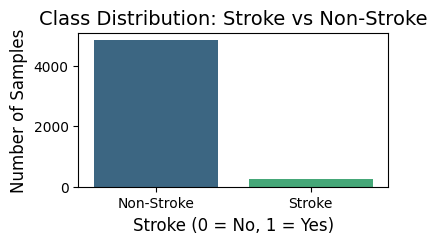

In [16]:
class_counts = data['stroke'].value_counts()

# Plot the class distribution
plt.figure(figsize=(4, 2))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution: Stroke vs Non-Stroke", fontsize=14)
plt.xlabel("Stroke (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks([0, 1], labels=['Non-Stroke', 'Stroke'])
plt.show()

In [17]:
!pip install imbalanced-learn

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('stroke', axis=1) 
y = data['stroke']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

Before SMOTE:
stroke
0    3889
1     199
Name: count, dtype: int64

After SMOTE:
stroke
0    3889
1    3889
Name: count, dtype: int64


In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the MLP Classifier
#Referenced from lab 3
clf1 = MLPClassifier(
    random_state=42,              
    activation='logistic',         
    hidden_layer_sizes=(128, 64, 32),  
    solver='adam',                 
    max_iter=500                   
)

# Train the classifier on the SMOTE-balanced data
clf1.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
clf1_predict = clf1.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf1_predict))
print("\nClassification Report:")
print(classification_report(y_test, clf1_predict))
print("\nAccuracy Score:")
print(accuracy_score(y_test, clf1_predict))


Confusion Matrix:
[[794 178]
 [ 38  12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       972
           1       0.06      0.24      0.10        50

    accuracy                           0.79      1022
   macro avg       0.51      0.53      0.49      1022
weighted avg       0.91      0.79      0.84      1022


Accuracy Score:
0.7886497064579256


In [54]:

# Initialize the MLP Classifier
clf2 = MLPClassifier(
    random_state=42,              
    activation='logistic',         
    hidden_layer_sizes=( 128, 64, 32),  
    solver='adam',                 
    max_iter=200                   
)

# Train the classifier on the SMOTE-balanced data
clf2.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
clf2_predict = clf2.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf2_predict))
print("\nClassification Report:")
print(classification_report(y_test, clf2_predict))
print("\nAccuracy Score:")
print(accuracy_score(y_test, clf2_predict))


Confusion Matrix:
[[1233  376]
 [ 203  104]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1609
           1       0.22      0.34      0.26       307

    accuracy                           0.70      1916
   macro avg       0.54      0.55      0.54      1916
weighted avg       0.76      0.70      0.72      1916


Accuracy Score:
0.6978079331941545


C:\Users\vrsru\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:

# Initialize the MLP Classifier
clf3 = MLPClassifier(
    random_state=42,              
    activation='logistic',         
    hidden_layer_sizes=( 128, 64, 32),  
    solver='adam',                 
    max_iter=800                   
)

# Train the classifier on the SMOTE-balanced data
clf3.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
clf3_predict = clf3.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf3_predict))
print("\nClassification Report:")
print(classification_report(y_test, clf3_predict))
print("\nAccuracy Score:")
print(accuracy_score(y_test, clf3_predict))


Confusion Matrix:
[[1233  376]
 [ 197  110]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1609
           1       0.23      0.36      0.28       307

    accuracy                           0.70      1916
   macro avg       0.54      0.56      0.54      1916
weighted avg       0.76      0.70      0.73      1916


Accuracy Score:
0.7009394572025052


### Dataset 2 : Loan Data

In [22]:
data = pd.read_csv("C:\\Users\\vrsru\\Downloads\\loan_data.csv")

In [23]:
#handling missing data

num_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
                'days.with.cr.line', 'revol.bal', 'revol.util']
cat_features = ['purpose']
num_imputer = SimpleImputer(strategy='mean')
data[num_features] = num_imputer.fit_transform(data[num_features])

In [24]:
data = pd.get_dummies(data, columns=cat_features, drop_first=True)

In [25]:
#scaling
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

In [26]:
#Feature Engineering
data['dti_fico_ratio'] = data['dti'] / (data['fico'] + 1e-5)

In [27]:
fico_bins = [300, 580, 670, 740, 850]
fico_labels = ['poor', 'fair', 'good', 'excellent']
data['fico_category'] = pd.cut(data['fico'] * 100 + 300, bins=fico_bins, labels=fico_labels)

In [28]:
data = pd.get_dummies(data, columns=['fico_category'], drop_first=True)

In [29]:
data.drop(columns=['fico'], inplace=True)

In [30]:
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(int)

In [31]:
data.to_csv("preprocessed_loan_data.csv", index=False)

In [32]:
print(data.head())

   credit.policy  int.rate  installment  log.annual.inc       dti  \
0              1 -0.139318     2.463099        0.680388  0.998505   
1              1 -0.578868    -0.438854        0.244031  0.244540   
2              1  0.486484     0.230708       -0.908659 -0.141885   
3              1 -0.813544    -0.757022        0.680388 -0.654697   
4              1  0.743509    -1.043992        0.597961  0.343326   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  ...  \
0           0.432230   0.353732    0.182704               0            0  ...   
1          -0.721230   0.495018    1.030602               0            0  ...   
2           0.059770  -0.397073   -0.730683               1            0  ...   
3          -0.745277   0.496321    0.909966               1            0  ...   
4          -0.198161  -0.360663   -0.251586               0            1  ...   

   purpose_credit_card  purpose_debt_consolidation  purpose_educational  \
0                    0 

C:\Users\vrsru\AppData\Local\Temp\ipykernel_16976\2244872141.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


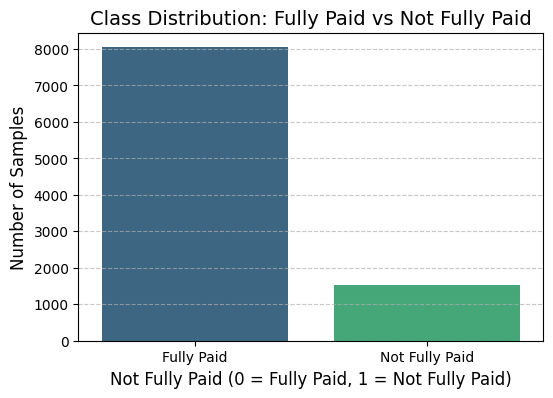

In [33]:
class_counts = data['not.fully.paid'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution: Fully Paid vs Not Fully Paid", fontsize=14)
plt.xlabel("Not Fully Paid (0 = Fully Paid, 1 = Not Fully Paid)", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks([0, 1], labels=['Fully Paid', 'Not Fully Paid'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [34]:
X = data.drop(columns=['not.fully.paid'])  
y = data['not.fully.paid'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

Before SMOTE:
not.fully.paid
0    6436
1    1226
Name: count, dtype: int64

After SMOTE:
not.fully.paid
0    6436
1    6436
Name: count, dtype: int64


In [56]:
clf_loan = MLPClassifier(
    random_state=42,               
    activation='relu',             
    hidden_layer_sizes=(128, 64, 32, 16),  
    solver='adam',                 
    max_iter=200                  
)

clf_loan.fit(X_train_smote, y_train_smote)

y_pred = clf_loan.predict(X_test)

# Evaluation Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[1313  296]
 [ 217   90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1609
           1       0.23      0.29      0.26       307

    accuracy                           0.73      1916
   macro avg       0.55      0.55      0.55      1916
weighted avg       0.76      0.73      0.74      1916


Accuracy Score:
0.7322546972860126


In [44]:
import sklearn
import matplotlib
import imblearn

In [45]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Imbalanced-learn version:", imblearn.__version__)

Pandas version: 2.2.2
NumPy version: 1.26.4
Scikit-learn version: 1.5.2
Matplotlib version: 3.8.4
Seaborn version: 0.13.2
Imbalanced-learn version: 0.13.0
